In [1]:
import mvpa2.suite as mv
from scipy.stats import zscore as sciz, pearsonr
import os.path, time
import glob
from scipy.io import loadmat 
import numpy as np
import pandas as pd
import nibabel as nb
import h5py
from mvpa2.datasets.base import Dataset
from mvpa2.misc.surfing.queryengine import SurfaceQueryEngine
from mvpa2.support.nibabel.surf import read as read_surface
from mvpa2.datasets.mri import fmri_dataset
from mvpa2.misc.neighborhood import IndexQueryEngine, Sphere
from mvpa2.datasets.base import mask_mapper
import mvpa2.misc.surfing.volume_mask_dict as volmask
from mvpa2.algorithms.searchlight_hyperalignment import SearchlightHyperalignment
from mvpa2.mappers.zscore import zscore
from mvpa2.base.hdf5 import h5save, h5load
from scipy.spatial.distance import pdist, cdist
import matplotlib.pyplot as plt


/dartfs-hpc/rc/home/1/f0040y1/.local/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif
/optnfs/common/miniconda3/envs/anaconda2/lib/python2.7/site-packages/_pytest/mark/structures.py:383: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


## Set Paths

In [2]:
helperfiles = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/helperfiles/'
chamats = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/CHA_matrices/'
logdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/log/'
scriptsdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/scripts/'
basedir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/'
mapdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/transformation_matrices/'
resultsdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/isc_results'

## Load Template to create Query Engine

In [3]:
# check if cleaned bladder files load to correct dimensions 
bladderdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/data/cleaned_bladder/'
ref_ds = fmri_dataset(os.path.join(bladderdir,'sub-M80302134_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii'), mask=os.path.join(helperfiles,'newbrainmask.nii'))


 * Please note: warnings are printed only once, but underlying problem might occur many times *


In [4]:
len(ref_ds.fa.voxel_indices)

170804

In [19]:
mydir = '/dartfs-hpc/rc/home/1/f0040y1/sub-M80399971_ses-1_task-bladder_space-MNI152NLin2009cAsym_desc-preproc_bold.nii'
#sample = fmri_dataset(mydir, mask=os.path.join(helperfiles,'newbrainmask.nii'))
sample = fmri_dataset(mydir)

In [20]:
sample.shape

(1628, 458294)

In [17]:
# load nifti as a pymvpa dataset and then use that as ref_ds in the queryengine definition
# mask with mymask
#ref_ds = fmri_dataset(os.path.join(helperfiles,'olp4cbp_qe_template.nii'), mask=os.path.join(helperfiles,'brainmask.nii'))
ref_ds = fmri_dataset(os.path.join(helperfiles,'canlab_atlas_for_CHA.nii'), mask=os.path.join(helperfiles,'newbrainmask.nii'))

len(ref_ds.fa.voxel_indices)


170804

In [19]:
sum(ref_ds.samples[0] != 0)

170804

In [13]:
ref_ds = fmri_dataset(os.path.join(helperfiles,'newbrainmask.nii'))

In [14]:
len(ref_ds.fa.voxel_indices)

902629

In [7]:
# set searchlight sphere radius
sl_radius = 3.0

#create query engine
qe = IndexQueryEngine(voxel_indices=Sphere(sl_radius))
qe.train(ref_ds)

## Load Subjects for Hyperalignning

In [3]:
# number of subjects connectomes to pull in
# specify number of targets in connectome
nsubs = 202
cnx_tx = 489

In [4]:
nfiles = glob.glob(os.path.join(chamats, 'ses1_only', '*'))
mysubs = nfiles[0:nsubs]

In [5]:
mysubs[201]

'/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/CHA_matrices/ses1_only/sub-M80399870_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy'

In [6]:
max(range(202))

201

In [8]:
# import connectomes into pymvpa dataset, zscore, then add chunks and voxel indices

ds = None
for sub in range(len(mysubs)):
    d = mv.Dataset(np.load(mysubs[sub]))
    mv.zscore(d, chunks_attr=None)
    mv.remove_invariant_features(d)
    print(d.shape)
    if ds is None:
        ds = d
    else:      
        ds = mv.vstack((ds,d))
ds.shape

(489, 170804)
(489, 170804)
(489, 170804)


KeyboardInterrupt: 

In [7]:
# import connectomes into pymvpa dataset, zscore, then add chunks and voxel indices, append to list of datsets

dss = []
for sub in range(len(mysubs)):
    ds = mv.Dataset(np.load(mysubs[sub]))
    ds.fa['voxel_indices'] = range(ds.shape[1])
    #ds.sa['chunks'] = np.repeat(i,cnx_tx)
    mv.zscore(ds, chunks_attr=None)
    dss.append(ds)


In [8]:
print('dss sizes')
print(len(dss))
print(dss[0].shape)

dss sizes
202
(489, 170804)


In [14]:
# cs = None
# for i in range(len(mysubs)):
#     thischunk = np.repeat(i,cnx_tx)
#     if cs is None:
#         cs = thischunk
#     else:
#         cs= np.hstack((cs, thischunk))
    

# ds.sa['chunks'] = cs
# ds.fa['voxel_indices'] = range(ds.shape[1])
# ds.shape

In [15]:
# print('ds Shape: ', ds.shape)
# print('Size of voxel_indices: ', len(ds.fa.voxel_indices))
# print('Size of chunks: ', len(ds.sa.chunks))

## Run Hyperalignment

In [16]:
# create SL hyperalignment instance
hyper = SearchlightHyperalignment(
    queryengine=qe,
    compute_recon=False, # We don't need to project back from common space to subject space
    nproc=1, 
)

In [17]:
# constants 
N_JOBS=16
N_BLOCKS=128
HYPERALIGNMENT_RADIUS=5

sl_radius = HYPERALIGNMENT_RADIUS
qe = IndexQueryEngine(voxel_indices=Sphere(sl_radius))
qe.train(ref_ds)

hyper = SearchlightHyperalignment(
    queryengine=qe,
    compute_recon=False, # We don't need to project back from common space to subject space
    nproc=N_JOBS, 
    nblocks=N_BLOCKS,
    dtype ='float64'
)

maps = hyper(dss)

RuntimeError: The 'pprocess' module is required for multiprocess searchlights. Please either install python-pprocess, or reduce `nproc` to 1 (got nproc=16) or set to default None

In [18]:
toutdir = os.path.join(basedir, 'transformation_matrices', 'olp4cbp_mappers' +'_' + str(len(mysubs)) + '_'+'subs_'+ '.hdf5.gz')
t0 = time.time()
mappers = hyper(dss)

try:
    h5save(toutdir, mappers)
    print('saved hdf5 mappers')
except: 
    print('could not save hdf5 mappers')

elapsed = time.time()-t0
print('-------- time elapsed: {elapsed} --------'.format(elapsed=(time.strftime("%H:%M:%S",time.gmtime(elapsed)))))
print('saving at location: {0}'.format(toutdir))

could not save hdf5 mappers
-------- time elapsed: 01:15:33 --------
saving at location: /dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/transformation_matrices


/optnfs/common/miniconda3/envs/anaconda2/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [37]:
toutdir = os.path.join(basedir, 'transformation_matrices', 'olp4cbp_mappers' +'_' + str(len(mysubs)) + '_'+'subs'+ '.hdf5.gz')
h5save(toutdir, mappers)

## Benchmark ISCs

In [ ]:
print(len(dss))
print(dss[0].shape)
mappers = h5load(os.path.join(mapdir,'olp4cbp_mappers_202_subs.hdf5.gz'))
dss_aligned = [mapper.forward(ds) for ds, mapper in zip(dss, mappers)]
print(len(mappers))
print(dss_aligned[0].shape)


202
(489, 170804)


/optnfs/common/miniconda3/envs/anaconda2/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [140]:
def compute_average_similarity(dss, metric='correlation'):
    """
    Returns
    =======
    sim : ndarray
        A 1-D array with n_features elements, each element is the average
        pairwise correlation similarity on the corresponding feature.
    """
    n_features = dss[0].shape[1]
    sim = np.zeros((n_features, ))
    for i in range(n_features):
        data = np.array([ds.samples[:, i] for ds in dss])
        dist = pdist(data, metric)
        sim[i] = 1 - dist.mean()
    return sim

In [87]:
n_features = dss[0].shape[1]
sim = np.zeros((n_features, ))

In [124]:
x = np.array([[1, 2, 3, 4],
              [1.5, 2, 3, 4]
              ])
y = np.array([[2, 4, 3, 2],
              [1, 2, 3, 4]
              ])

a  = np.array([[[1.0]],
              [[2.0]]
              ])
b = np.array([[[5.0]],
              [[3.0]]
              ])
c = np.array([[[5.0]],
              [[4.0]]
              ])
tds = [a,b,c]
len(tds)
z = compute_average_similarity(tds)

ValueError: A 2-dimensional array must be passed.

In [126]:
# data is the list of datasets
# align is a string indicating the type of data being used
# save is a boolean

def vertex_isc(data, align, save=True):
    all_results = []
    all_subjs = np.arange(data.shape[0])
    # loop through all vertices
    for v in np.arange(len(dss)):
        results = []
        data_v = data[:,:,v]
        for subj, ds in enumerate(data_v):
            group = np.setdiff1d(all_subjs, subj) # make groups
            group_avg = np.mean(data_v[group,:], axis=0).ravel()
            r = np.corrcoef(group_avg, ds.ravel())[0,1]
            results.append(r)
        all_results.append(np.array(results))
	#all_results.append(np.mean(np.array(results)))
    res = np.array(all_results)
    print(align)
    print(res.shape)
    if save:
        np.save(resultsdir+'{a}_vertex_isc_2d.npy'.format(a=align), res)
        print(resultsdir+'{a}_vertex_isc_2d.npy'.format(a=align))
    return res

#### 10 subs

In [3]:
isc_ha = h5load(os.path.join(resultsdir,'cha_isc_10_subs.hdf5.gz'))
isc_aa = h5load(os.path.join(resultsdir,'anatomical_isc_10_subs.hdf5.gz'))

In [4]:
print(np.mean(isc_aa))
print(np.min(isc_aa))
print(np.max(isc_aa))

0.11139680057244351
-0.05179146085390762
0.46513842296461116


#### 202 subs radius 5

In [3]:
isc_ha = h5load(os.path.join(resultsdir,'cha_isc_subs-202_radius5.hdf5.gz'))
isc_aa = h5load(os.path.join(resultsdir,'anatomical_isc_subs-202_radius-5.hdf5.gz'))

In [4]:
print(np.mean(isc_ha))
print(np.min(isc_ha))
print(np.max(isc_ha))

0.39537580521414856
0.06555137371049324
0.5872995121773268


In [7]:
print(np.mean(isc_aa))
print(np.min(isc_aa))
print(np.max(isc_aa))

0.12241049743630945
-0.001553231449507475
0.48876207862839816


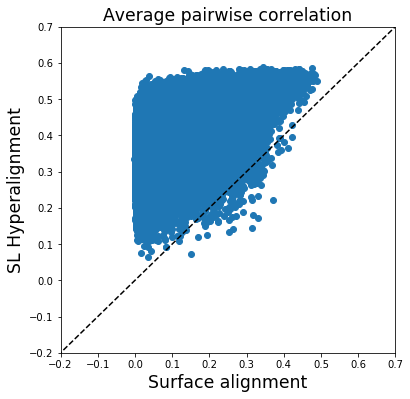

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(isc_aa, isc_ha)
plt.xlim([-.2, .7])
plt.ylim([-.2, .7])
plt.xlabel('Surface alignment', size='xx-large')
plt.ylabel('SL Hyperalignment', size='xx-large')
plt.title('Average pairwise correlation', size='xx-large')
plt.plot([-1, 1], [-1, 1], 'k--')
plt.show()

#### 202 Subjects Radius 10

In [10]:
isc_ha5 = h5load(os.path.join(resultsdir,'cha_isc_subs-202_radius-5.hdf5.gz'))
isc_ha10 = h5load(os.path.join(resultsdir,'cha_isc_subs-202_radius-10.hdf5.gz'))
isc_aa = h5load(os.path.join(resultsdir,'anatomical_isc_subs-202_radius-5.hdf5.gz'))

In [11]:
# AA
print(np.mean(isc_aa))
print(np.min(isc_aa))
print(np.max(isc_aa))

0.12241049743630945
-0.001553231449507475
0.48876207862839816


In [12]:
# CHA 5
print(np.mean(isc_ha5))
print(np.min(isc_ha5))
print(np.max(isc_ha5))

0.39537580521414856
0.06555137371049324
0.5872995121773268


In [13]:
# CHA 10
print(np.mean(isc_ha10))
print(np.min(isc_ha10))
print(np.max(isc_ha10))

0.45374004582994376
0.1845676095966109
0.6182551243490807


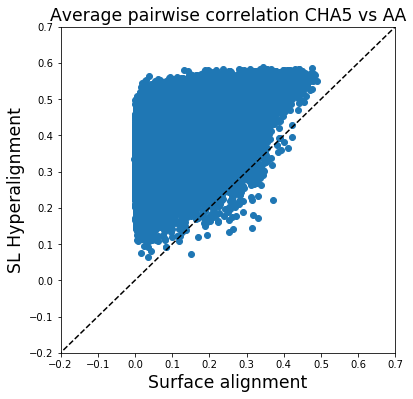

In [15]:
# plt CHA 5 vs AA
plt.figure(figsize=(6, 6))
plt.scatter(isc_aa, isc_ha5)
plt.xlim([-.2, .7])
plt.ylim([-.2, .7])
plt.xlabel('Surface alignment', size='xx-large')
plt.ylabel('SL Hyperalignment', size='xx-large')
plt.title('Average pairwise correlation CHA5 vs AA', size='xx-large')
plt.plot([-1, 1], [-1, 1], 'k--')
plt.show()

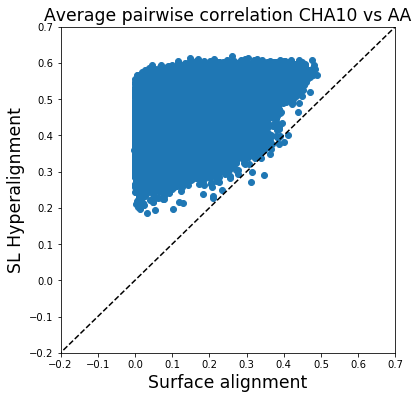

In [16]:
# plt CHA 10 vs AA
plt.figure(figsize=(6, 6))
plt.scatter(isc_aa, isc_ha10)
plt.xlim([-.2, .7])
plt.ylim([-.2, .7])
plt.xlabel('Surface alignment', size='xx-large')
plt.ylabel('SL Hyperalignment', size='xx-large')
plt.title('Average pairwise correlation CHA10 vs AA', size='xx-large')
plt.plot([-1, 1], [-1, 1], 'k--')
plt.show()

## Convert all CSV files to pickled numpy arrays

In [ ]:
import glob
import os.path
import pandas as pd
import numpy as np

openpath = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/CHA_matrices'
savepath = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/CHA_matrices/ndarrays'
myfiles = glob.glob(os.path.join(openpath,'*ses-1*'))

for f in myfiles:
    mysub = pd.read_csv(f, sep=',',header=None)
    npsub = mysub.to_numpy()
    fname1 = os.path.split(f)[1]
    fname = fname1[0:-4] + '.npy'
    ffull = os.path.join(savepath, fname)
    np.save(ffull, npsub, allow_pickle=True)

In [ ]:
for subj in test_subs:
    ds = Dataset(subj)
    idx = np.where(np.logical_not(np.all(ds.samples == 0, axis=0)))[0]
        ds = ds[:, idx]
        dss.append(ds)

## Check Bladder Pain Confound files

#### Check Bladder Confound files

In [19]:
from glob import glob
import os.path
confoundpath = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/first_level/'
x = [os.path.basename(x) for x in glob(os.path.join(confoundpath, '*'))]

real = []
notreal = []
for i in range(len(x)):
    mypath = os.path.join(confoundpath, x[i], 'ses-01/spm_modeling/bladder_confounds.mat')
    mypath
    if os.path.exists(mypath):
        real.append(x[i])
    else:
        notreal.append(x[i])
        

#### Check brain data files

In [ ]:
from glob import glob
import os.path
confoundpath = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP/Imaging/preprocessed/fmriprep'
x = [os.path.basename(x) for x in glob(os.path.join(confoundpath, '*'))]

real = []
notreal = []
for i in range(len(x)):
    mypath = os.path.join(confoundpath, x[i], 'ses-01/spm_modeling/bladder_confounds.mat')
    mypath
    if os.path.exists(mypath):
        real.append(x[i])
    else:
        notreal.append(x[i])

In [69]:
from glob import glob
import os.path
confoundpath = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP/Imaging/preprocessed/fmriprep'
x = [os.path.basename(x) for x in glob(os.path.join(confoundpath, '*'))]
files = []
for z in x:
    if os.path.isdir(os.path.join(confoundpath, z)):
        files.append(z)
files

['sub-M80390470',
 'sub-M80352280',
 'sub-M80357658',
 'sub-M80324276',
 'sub-M80391633',
 'sub-M80326076',
 'sub-M80395778',
 'sub-M80346209',
 'sub-M80374205',
 'sub-M80387207',
 'sub-M80358852',
 'sub-M80333899',
 'sub-M80305453',
 'sub-M80313660',
 'sub-M80358201',
 'sub-M80310232',
 'sub-M80326904',
 'sub-M80391055',
 'sub-M80354415',
 'sub-M80370470',
 'sub-M80352349',
 'sub-M80336970',
 'sub-M80334610',
 'sub-M80374686',
 'sub-M80321321',
 'sub-M80386647',
 'sub-M80384594',
 'sub-M80321700',
 'sub-M80340554',
 'sub-M80387585',
 'sub-M80398382',
 'sub-M80358716',
 'sub-M80344484',
 'sub-M80363982',
 'sub-M80354222',
 'sub-M80365070',
 'sub-M80370264',
 'sub-M80336871',
 'sub-M80394681',
 'sub-M80395867',
 'sub-M80330026',
 'sub-M80390618',
 'sub-M80340398',
 'sub-M80308229',
 'sub-M80316833',
 'sub-M80370429',
 'sub-M80359226',
 'sub-M80303741',
 'sub-M80317666',
 'sub-M80316294',
 'sub-M80335769',
 'sub-M80337218',
 'sub-M80364787',
 'sub-M80345974',
 'sub-M80352012',
 'sub-M803

In [96]:
real = []
notreal = []
for i in range(len(files)):
    mypath = os.path.join(confoundpath, files[i], 'ses-1/func/', (files[i] +'_ses-1_task-bladder_space-MNI152NLin2009cAsym_desc-preproc_bold.nii'))
    mypath2 = os.path.join(confoundpath, files[i], 'ses-1/func/', (files[i] +'_ses-1_task-bladder_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
    if os.path.exists(mypath) or os.path.exists(mypath2):
        real.append(files[i])
    else:
        notreal.append(files[i])

In [97]:
real

['sub-M80390470',
 'sub-M80352280',
 'sub-M80357658',
 'sub-M80324276',
 'sub-M80391633',
 'sub-M80326076',
 'sub-M80395778',
 'sub-M80346209',
 'sub-M80374205',
 'sub-M80387207',
 'sub-M80358852',
 'sub-M80333899',
 'sub-M80305453',
 'sub-M80313660',
 'sub-M80358201',
 'sub-M80310232',
 'sub-M80326904',
 'sub-M80391055',
 'sub-M80354415',
 'sub-M80370470',
 'sub-M80352349',
 'sub-M80336970',
 'sub-M80334610',
 'sub-M80374686',
 'sub-M80321321',
 'sub-M80386647',
 'sub-M80384594',
 'sub-M80321700',
 'sub-M80340554',
 'sub-M80387585',
 'sub-M80398382',
 'sub-M80358716',
 'sub-M80344484',
 'sub-M80363982',
 'sub-M80354222',
 'sub-M80365070',
 'sub-M80370264',
 'sub-M80336871',
 'sub-M80394681',
 'sub-M80395867',
 'sub-M80330026',
 'sub-M80390618',
 'sub-M80340398',
 'sub-M80308229',
 'sub-M80316833',
 'sub-M80370429',
 'sub-M80359226',
 'sub-M80303741',
 'sub-M80317666',
 'sub-M80316294',
 'sub-M80335769',
 'sub-M80337218',
 'sub-M80364787',
 'sub-M80345974',
 'sub-M80352012',
 'sub-M803

In [98]:
notreal

['logs']

In [99]:
files

['sub-M80390470',
 'sub-M80352280',
 'sub-M80357658',
 'sub-M80324276',
 'sub-M80391633',
 'sub-M80326076',
 'sub-M80395778',
 'sub-M80346209',
 'sub-M80374205',
 'sub-M80387207',
 'sub-M80358852',
 'sub-M80333899',
 'sub-M80305453',
 'sub-M80313660',
 'sub-M80358201',
 'sub-M80310232',
 'sub-M80326904',
 'sub-M80391055',
 'sub-M80354415',
 'sub-M80370470',
 'sub-M80352349',
 'sub-M80336970',
 'sub-M80334610',
 'sub-M80374686',
 'sub-M80321321',
 'sub-M80386647',
 'sub-M80384594',
 'sub-M80321700',
 'sub-M80340554',
 'sub-M80387585',
 'sub-M80398382',
 'sub-M80358716',
 'sub-M80344484',
 'sub-M80363982',
 'sub-M80354222',
 'sub-M80365070',
 'sub-M80370264',
 'sub-M80336871',
 'sub-M80394681',
 'sub-M80395867',
 'sub-M80330026',
 'sub-M80390618',
 'sub-M80340398',
 'sub-M80308229',
 'sub-M80316833',
 'sub-M80370429',
 'sub-M80359226',
 'sub-M80303741',
 'sub-M80317666',
 'sub-M80316294',
 'sub-M80335769',
 'sub-M80337218',
 'sub-M80364787',
 'sub-M80345974',
 'sub-M80352012',
 'sub-M803

## Check number and order of sponpain vs. bladder brain files

In [8]:
from glob import glob
import os.path
spondir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/CHA_matrices/sponpain/ses1_only'
bladdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/data/cleaned_bladder'

In [11]:
# this is the order that files are loaded into hyperalignment
sponfiles = [os.path.basename(x) for x in glob(os.path.join(spondir, '*ses-*'))]
sponfiles

['sub-M80326819_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy',
 'sub-M80366570_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy',
 'sub-M80309706_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy',
 'sub-M80398382_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy',
 'sub-M80360072_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy',
 'sub-M80328230_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy',
 'sub-M80374205_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy',
 'sub-M80399337_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy',
 'sub-M80333899_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy',
 'sub-M80302799_ses-1_task-sponpain_space-MNI152NLin200

In [12]:
len(sponfiles)

202

In [13]:
sponsubs = [z[0:13] for z in sponfiles]
sponsubs

['sub-M80326819',
 'sub-M80366570',
 'sub-M80309706',
 'sub-M80398382',
 'sub-M80360072',
 'sub-M80328230',
 'sub-M80374205',
 'sub-M80399337',
 'sub-M80333899',
 'sub-M80302799',
 'sub-M80370204',
 'sub-M80375622',
 'sub-M80340554',
 'sub-M80354166',
 'sub-M80370470',
 'sub-M80336083',
 'sub-M80372078',
 'sub-M80320091',
 'sub-M80352006',
 'sub-M80363223',
 'sub-M80378375',
 'sub-M80389422',
 'sub-M80340964',
 'sub-M80395955',
 'sub-M80358201',
 'sub-M80351764',
 'sub-M80316805',
 'sub-M80344908',
 'sub-M80395860',
 'sub-M80365070',
 'sub-M80304426',
 'sub-M80321756',
 'sub-M80310232',
 'sub-M80362227',
 'sub-M80399265',
 'sub-M80395778',
 'sub-M80326076',
 'sub-M80366943',
 'sub-M80396887',
 'sub-M80390470',
 'sub-M80310778',
 'sub-M80388445',
 'sub-M80332055',
 'sub-M80374029',
 'sub-M80352012',
 'sub-M80370429',
 'sub-M80318052',
 'sub-M80330026',
 'sub-M80317076',
 'sub-M80302134',
 'sub-M80358718',
 'sub-M80336970',
 'sub-M80386115',
 'sub-M80321202',
 'sub-M80348133',
 'sub-M803

In [14]:
bladfiles = [os.path.basename(x) for x in glob(os.path.join(bladdir, 'sub*ses-1*.nii'))]
bladfiles

['sub-M80309434_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80340964_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80306684_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80312814_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80336524_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80375622_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80398666_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80350874_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80326890_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80373984_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80390646_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii',
 'sub-M80302799_ses-1_task-bladderpain_spac

In [15]:
len(bladfiles)

203

In [17]:
bladsubs = [z[0:13] for z in bladfiles]
bladsubs

['sub-M80309434',
 'sub-M80340964',
 'sub-M80306684',
 'sub-M80312814',
 'sub-M80336524',
 'sub-M80375622',
 'sub-M80398666',
 'sub-M80350874',
 'sub-M80326890',
 'sub-M80373984',
 'sub-M80390646',
 'sub-M80302799',
 'sub-M80344484',
 'sub-M80321641',
 'sub-M80348133',
 'sub-M80362430',
 'sub-M80362938',
 'sub-M80389422',
 'sub-M80366943',
 'sub-M80371745',
 'sub-M80383944',
 'sub-M80321700',
 'sub-M80304397',
 'sub-M80330026',
 'sub-M80316037',
 'sub-M80365070',
 'sub-M80336833',
 'sub-M80370429',
 'sub-M80305800',
 'sub-M80373165',
 'sub-M80310232',
 'sub-M80349728',
 'sub-M80395521',
 'sub-M80354415',
 'sub-M80388445',
 'sub-M80334610',
 'sub-M80344098',
 'sub-M80317666',
 'sub-M80354166',
 'sub-M80363223',
 'sub-M80336871',
 'sub-M80386115',
 'sub-M80384493',
 'sub-M80393391',
 'sub-M80337218',
 'sub-M80310778',
 'sub-M80384594',
 'sub-M80336970',
 'sub-M80320091',
 'sub-M80387585',
 'sub-M80399870',
 'sub-M80304717',
 'sub-M80341407',
 'sub-M80382492',
 'sub-M80369669',
 'sub-M803

In [18]:
# these are subs who have bladder pain data but no spontaneous connectome
listdiff1 = [sub for sub in bladsubs if sub not in sponsubs]
listdiff1

['sub-M80321700', 'sub-M80395521']

In [19]:
# these are subs who have spontaneous connectomes but not bladder pain data
listdiff2 = [sub for sub in sponsubs if sub not in bladsubs]
listdiff2

['sub-M80340398']

In [28]:
# get a list of indices from the sponpain list (which corresponds to the order of CHA mappers) that does not include
# participants who aren't in both lists. mapper_indices will be used to load mappers, and p_list will be used to load 
# bladder data
mapper_indices = []
p_list = []
for sub in sponsubs:
    if sub in bladsubs and sub in sponsubs:
        mapper_indices.append(sponsubs.index(sub))
        p_list.append(sub)
    else:
        print(sub)

sub-M80340398


In [47]:
mappers = h5load(os.path.join(mapdir,'olp4cbp_mappers_subs-202_radius-10.hdf5.gz'))
print('Mappers Loaded.')
savedir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/common_spaces/bladderpain/commonspace_subs-201_radius-10/'

for i, sub in enumerate(p_list):
    this_blad = os.path.join(bladdir, sub + '_ses-1_task-bladderpain_space-canlab2018-2mm_desc-preproc-cleaned.nii')
    if os.path.isfile(this_blad):
        ds = fmri_dataset(this_blad, mask=os.path.join(helperfiles,'newbrainmask.nii'))
        ds_mapped = mappers[mapper_indices[i]].forward(ds)
        np.save(savedir + sub + '_commonspace-bladderinspon_subs-202_radius-10', ds_mapped)
    else:
        print('File does not exist: ')
        print(this_blad)
        break
    
    
    #dss_aligned = [mapper.forward(ds) for ds, mapper in zip(dss, mappers)]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
dss = []
for sub in range(len(mysubs)):
    ds = mv.Dataset(np.load(mysubs[sub]))
    ds.fa['voxel_indices'] = range(ds.shape[1])
    #ds.sa['chunks'] = np.repeat(i,cnx_tx)
    mv.zscore(ds, chunks_attr=None)
    dss.append(ds)


In [68]:
savedir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/common_spaces/bladderpain/commonspace_subs-201_radius-10/'
savedir + sub + '_commonspace-bladderinspon_subs-202_radius-10'

'/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/common_spaces/bladderpain/commonspace_subs-201_radius-10/sub-M80326819_commonspace-bladderinspon_subs-202_radius-10'

In [65]:
sub = p_list[0]

In [53]:
mappers = h5load(os.path.join(mapdir,'olp4cbp_mappers_subs-202_radius-10.hdf5.gz'))

/optnfs/common/miniconda3/envs/anaconda2/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [61]:
x = mappers[0].forward(ds)

In [63]:
x.shape

(1613, 170804)

## Convert npy to nii

In [5]:
from glob import glob
import os.path

datadir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/common_spaces/bladderpain/commonspace_subs-201_radius-10'

# get list of npy files to convert
myfiles = glob(os.path.join(datadir, '*.npy'))

In [14]:
for sub in myfiles:
    mysub = mv.Dataset(np.load(sub))
    savepath = os.path.join(datadir, os.path.split(sub)[1][0:-4] + '.hdf5.gz')
    h5save(savepath, mysub)

sub-M80340964_commonspace-bladderinspon_subs-201_radius-10
sub-M80375143_commonspace-bladderinspon_subs-201_radius-10
sub-M80390470_commonspace-bladderinspon_subs-201_radius-10
sub-M80321201_commonspace-bladderinspon_subs-202_radius-10
sub-M80321120_commonspace-bladderinspon_subs-201_radius-10
sub-M80364787_commonspace-bladderinspon_subs-201_radius-10
sub-M80352349_commonspace-bladderinspon_subs-201_radius-10
sub-M80357200_commonspace-bladderinspon_subs-201_radius-10
sub-M80391633_commonspace-bladderinspon_subs-201_radius-10
sub-M80360754_commonspace-bladderinspon_subs-201_radius-10
sub-M80337218_commonspace-bladderinspon_subs-201_radius-10
sub-M80304738_commonspace-bladderinspon_subs-201_radius-10
sub-M80348133_commonspace-bladderinspon_subs-201_radius-10
sub-M80331231_commonspace-bladderinspon_subs-201_radius-10
sub-M80341717_commonspace-bladderinspon_subs-201_radius-10
sub-M80356200_commonspace-bladderinspon_subs-201_radius-10
sub-M80317076_commonspace-bladderinspon_subs-201_radius-

In [10]:
savepath = '/dartfs-hpc/rc/home/1/f0040y1'
mysub = mv.Dataset(np.load(myfiles[0]))
savepath = os.path.join(datadir, os.path.split(myfiles[0])[1][0:-4] + '.hdf5.gz')
h5save(savepath, mysub)

In [2]:
thisf = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/OLP4CBP/hyperalignment/common_spaces/bladderpain/commonspace_subs-201_radius-10/sub-M80399971_commonspace-bladderinspon_subs-201_radius-10.hdf5.gz'

In [9]:
myfiles[0]

'/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/common_spaces/bladderpain/commonspace_subs-201_radius-10/sub-M80340964_commonspace-bladderinspon_subs-201_radius-10.npy'

In [4]:
x

Dataset(array([[ -295.70522385,  1485.03352022,  -693.59557623, ...,
        -2906.24523127, -2790.89092832,  3706.42371958],
       [ -327.17026107,  1546.23675635,  -703.49562868, ...,
        -2781.23489576, -2620.01382654,  3813.4041165 ],
       [ -283.95250925,  1489.94313105,  -729.3628816 , ...,
        -2963.62546293, -2805.63831606,  3561.20472891],
       ...,
       [ -324.26858157,  1525.34413066,  -688.21894141, ...,
        -2825.46009998, -2763.49212381,  3636.50555872],
       [ -350.76792331,  1554.42140065,  -703.99495342, ...,
        -2862.67530517, -2752.49645565,  3380.1771269 ],
       [ -331.0620521 ,  1572.47979168,  -692.57011872, ...,
        -2840.92696002, -2731.94715155,  3563.0964053 ]]), sa=SampleAttributesCollection(items=[]), fa=FeatureAttributesCollection(items=[]), a=DatasetAttributesCollection(items=[]))

In [2]:
bladderdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/data/cleaned_bladder'
spondir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/projects/OLP4CBP/hyperalignment/common_spaces/bladderpain/commonspace_subs-201_radius-10'

In [26]:
import nibabel as nib
ds = nib.load('canlab_atlas_for_CHA.nii').get_fdata()

In [28]:
ds.shape

(91, 109, 91)

In [21]:
ds.get_fdata()

AttributeError: 'memmap' object has no attribute 'header'

In [29]:
import mvpa2.suite as mv

/dartfs-hpc/rc/home/1/f0040y1/.local/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif
/optnfs/common/miniconda3/envs/anaconda2/lib/python2.7/site-packages/_pytest/mark/structures.py:383: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [37]:
cd ../parcelwise/helper_files/

/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/OLP4CBP/hyperalignment/parcelwise/helper_files


In [39]:
np.load('resampled_canlab2018_2mm_mask.mat')

ValueError: Cannot load file containing pickled data when allow_pickle=False